# Clustering of HCP Unrelated 100 Subjects by ROI-Correlations in Resting State fMRI

## Introduction

MRI (Magnetic Resonance Imaging) is a procedure in medical diagnostics which aims to produce three-dimensional images of the body. In comparison to X-Ray and Computertomography it does not incorporate the usage of ionizing radiation and is primarily used for evaluating anatomy and physiology of soft tissue. It's based on the nuclear spin of hydrogen atoms, which can be measured by applying different techniques regarding magnetic fields. An advancement of this process is called fMRI which means functional MRI. This procedure uses the so called BOLD-contrast which stands for blood-oxygen-level dependent contrast. Due to the difference in the magneticity of oxygenrich blood and the one low in oxygen neural activity in the brain can be measured.
The HCP (Human Connectom Project) is researching human connectomics, the connections in the brain, on different scales (e.g. between regions or individual neurons). MEG, EEG and MRI has been performed on about 1200 patients. In addition, genetic sequencing and several sensory and motoric test as well as cognitive evaluation took place. At this point this work is using only parts of the resting state fMRI data (specifically Resting State fMRI 1 FIX-Denoised Extended) in the HCP Unrelated 100 dataset. This is due to considerations regarding storage space as well as processing time and power. Therefore, only the first session in the downloaded data has been used until now.

## Implementation

### Import and Setup

In [1]:
from Main import timeseries_pearson_corr
from Import import get_parcellation_data, img_data_loader
from Visualization import create_network_graph_frames, plot_in_orientation
from glob import glob
from matplotlib.lines import Line2D
from matplotlib.colors import ListedColormap
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearnex import patch_sklearn
import re
import os
import cv2
import matplotlib.pyplot as plt
import networkx as nx
import nibabel as nib
import nilearn.image as nimg
import numpy as np
import pandas as pd
import seaborn as sns
patch_sklearn()
%matplotlib inline

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


#### Notes
Timeseries and centroids have been computed in additional so-called generator files to make use of multiprocessing. Therefore, this data has to be imported first.
In the first part of this notebook most calculations and visualizations have been calculated on only one patient. The other patients data is later used for the clustering.

In [2]:
# import all timeseries
files = glob("D:/HCP/Unrelated 100/Patients/timeseries/*")
all_timeseries = [np.load(file) for file in files]
len(all_timeseries)

100

In [3]:
# import all centroids
files = glob("./Data/centroids/*")
all_centroids = np.concatenate([np.load(file) for file in files], axis=0)
all_centroids

array([[64.46511628, 59.51928531, 60.82019285],
       [24.44957113, 58.22508134, 61.40490979],
       [54.38649625, 79.74492915, 56.47707697],
       [34.1984714 , 77.95512821, 57.25221893],
       [53.41225337, 85.95950156, 28.64070613],
       [35.9107322 , 86.30892678, 28.25275827],
       [61.87949825, 78.7446021 , 53.06539173],
       [26.30407524, 78.87539185, 52.40713166],
       [60.44256757, 87.57094595, 30.50675676],
       [28.55270936, 88.63743842, 29.92906404],
       [69.39788054, 68.74566474, 44.90077071],
       [20.03645461, 69.83774124, 46.09792709],
       [67.94503756, 77.33333333, 42.29141953],
       [19.9693166 , 77.45095305, 42.40864714],
       [63.12011834, 77.74615385, 29.2704142 ],
       [24.54481547, 78.4973638 , 29.37082601],
       [68.7030303 , 58.11212121, 42.31919192],
       [18.80916604, 59.23140496, 42.6649136 ],
       [47.84536563, 64.77503493, 66.03213787],
       [40.87684521, 62.45339519, 66.25643189],
       [49.13214286, 69.93214286, 29.657

In [5]:
# load atlas data
region_maps, region_maps_data, masked_aal, regions, region_labels = get_parcellation_data(fetched=True)

Atlas has been loaded.


In [6]:
region_labels

array([['FAG', 'Precentral_L', '2001'],
       ['FAD', 'Precentral_R', '2002'],
       ['F1G', 'Frontal_Sup_L', '2101'],
       ['F1D', 'Frontal_Sup_R', '2102'],
       ['F1OG', 'Frontal_Sup_Orb_L', '2111'],
       ['F1OD', 'Frontal_Sup_Orb_R', '2112'],
       ['F2G', 'Frontal_Mid_L', '2201'],
       ['F2D', 'Frontal_Mid_R', '2202'],
       ['F2OG', 'Frontal_Mid_Orb_L', '2211'],
       ['F2OD', 'Frontal_Mid_Orb_R', '2212'],
       ['F3OPG', 'Frontal_Inf_Oper_L', '2301'],
       ['F3OPD', 'Frontal_Inf_Oper_R', '2302'],
       ['F3TG', 'Frontal_Inf_Tri_L', '2311'],
       ['F3TD', 'Frontal_Inf_Tri_R', '2312'],
       ['F3OG', 'Frontal_Inf_Orb_L', '2321'],
       ['F3OD', 'Frontal_Inf_Orb_R', '2322'],
       ['ORG', 'Rolandic_Oper_L', '2331'],
       ['ORD', 'Rolandic_Oper_R', '2332'],
       ['SMAG', 'Supp_Motor_Area_L', '2401'],
       ['SMAD', 'Supp_Motor_Area_R', '2402'],
       ['COBG', 'Olfactory_L', '2501'],
       ['COBD', 'Olfactory_R', '2502'],
       ['FMG', 'Frontal_Sup_Medial

In [7]:
# setup
# patients = ["100307", "100408", "101107", "101309", "101915", "103111", "103414", "103818", "105014", "105115", "106016", "108828", "110411", "111312", "111716", "113619", "113922", "114419", "115320", "116524", "117122", "118528", "118730", "118932", "120111", "122317", "122620", "123117", "123925", "124422", "125525", "126325", "127630", "127933", "128127", "128632", "129028", "130013", "130316", "131217", "131722", "133019", "133928", "135225", "135932", "136833", "138534", "139637", "140925", "144832", "146432", "147737", "148335", "148840", "149337", "149539", "149741", "151223", "151526", "151627", "153025", "154734", "156637", "159340", "160123", "161731", "162733", "163129", "176542", "178950", "188347", "189450", "190031", "192540", "196750", "198451", "199655", "201111", "208226", "211417", "211720", "212318", "214423", "221319", "239944", "245333", "280739", "298051", "366446", "397760", "414229", "499566", "654754", "672756", "751348", "756055", "792564", "856766", "857263", "899885"]
df = pd.read_csv("./Data/unrestricted_lukasbehammer_6_5_2023_11_42_11.csv")
df[['Subject', 'Gender']] = df[['Subject', 'Gender']].astype("string")
gender = df.loc[:, "Gender"].to_numpy()
subjects = df.loc[:, "Subject"].tolist()
subject_id = "100307"
subject_num = subjects.index(subject_id)    # get patient index

timestamp = 70

# region_to_plot = str("F3TG")
# region_to_plot = str("VER9")
region_to_plot = str("ING")
region_index = np.where(region_labels == region_to_plot)
region_id = int(region_labels[region_index[0], 2])

# slices for "F3TG"
# sagittal_slice = 70
# coronal_slice = 70
# transversal_slice = 45

# slices for brain center
sagittal_slice = int(91/2)
coronal_slice = int(109/2)
transversal_slice = int(91/2)

orientations = ['transversal', 'sagittal', 'coronal']
slices = [transversal_slice, sagittal_slice, coronal_slice]

# setup colors
regions_n = len(regions)
colors = plt.cm.turbo(np.linspace(0, 1, regions_n)) # divide matplotlib cmap in regions_n values

#setup threshold for strength of correlation
correlation_threshold = 0.7
correlation_threshold_for_visualization = 0.9

In [7]:
# load Average T1w Image
path_T1w = "./Data/S1200_AverageT1w_restore.nii.gz"
img_T1w, img_data_T1w = img_data_loader(path_T1w)

In [8]:
# load specific fMRI Image
path_fMRI = os.path.join("D:/HCP/Unrelated 100/Patients", subject_id, "MNINonLinear/Results/rfMRI_REST1_LR/rfMRI_REST1_LR_hp2000_clean.nii.gz")
img_fMRI = nib.load(path_fMRI)  # not possible with wrapper function "img_data_loader" due to high storage needs
short, long = min(img_fMRI.shape[:3]), max(img_fMRI.shape[:3])  # length of short and long side of fMRI image (91px & 109px)

### Visualize Brain Regions

Visualization is important to get a feel for the data and later for assigning the correct views and locations of region centroids. The brain can be assigned different areas, which can be determined by different parameters, for example anatomic (e.g. cell types) or physiological (e.g. physiological function of the areas). Those areas are often called regions of interest (ROIs) and are usually saved in a so called parcellation atlas. For this work the aal atlas via the nilearn package is used (see Import.py --> get_parcellation_data).

In [9]:
# resample Images to region labels
resampled_img_data_T1w = nimg.resample_to_img(img_T1w, region_maps, interpolation='nearest').get_fdata()
resampled_img_fMRI = nimg.resample_to_img(img_fMRI, region_maps, interpolation='nearest') if img_fMRI.shape[0:3] != region_maps.shape else img_fMRI # resampling only if necessary
resampled_img_data_fMRI = resampled_img_fMRI.dataobj[:, :, :, timestamp]    # same as .get_fdata() but needs less storage
# mask all but the chosen region in aal atlas
masked_aal_region = np.ma.masked_where(masked_aal != region_id, masked_aal)
# mask fMRI image so that values of 0 are not shown
resampled_img_data_fMRI_masked = np.ma.masked_where(resampled_img_data_fMRI == 0, resampled_img_data_fMRI)

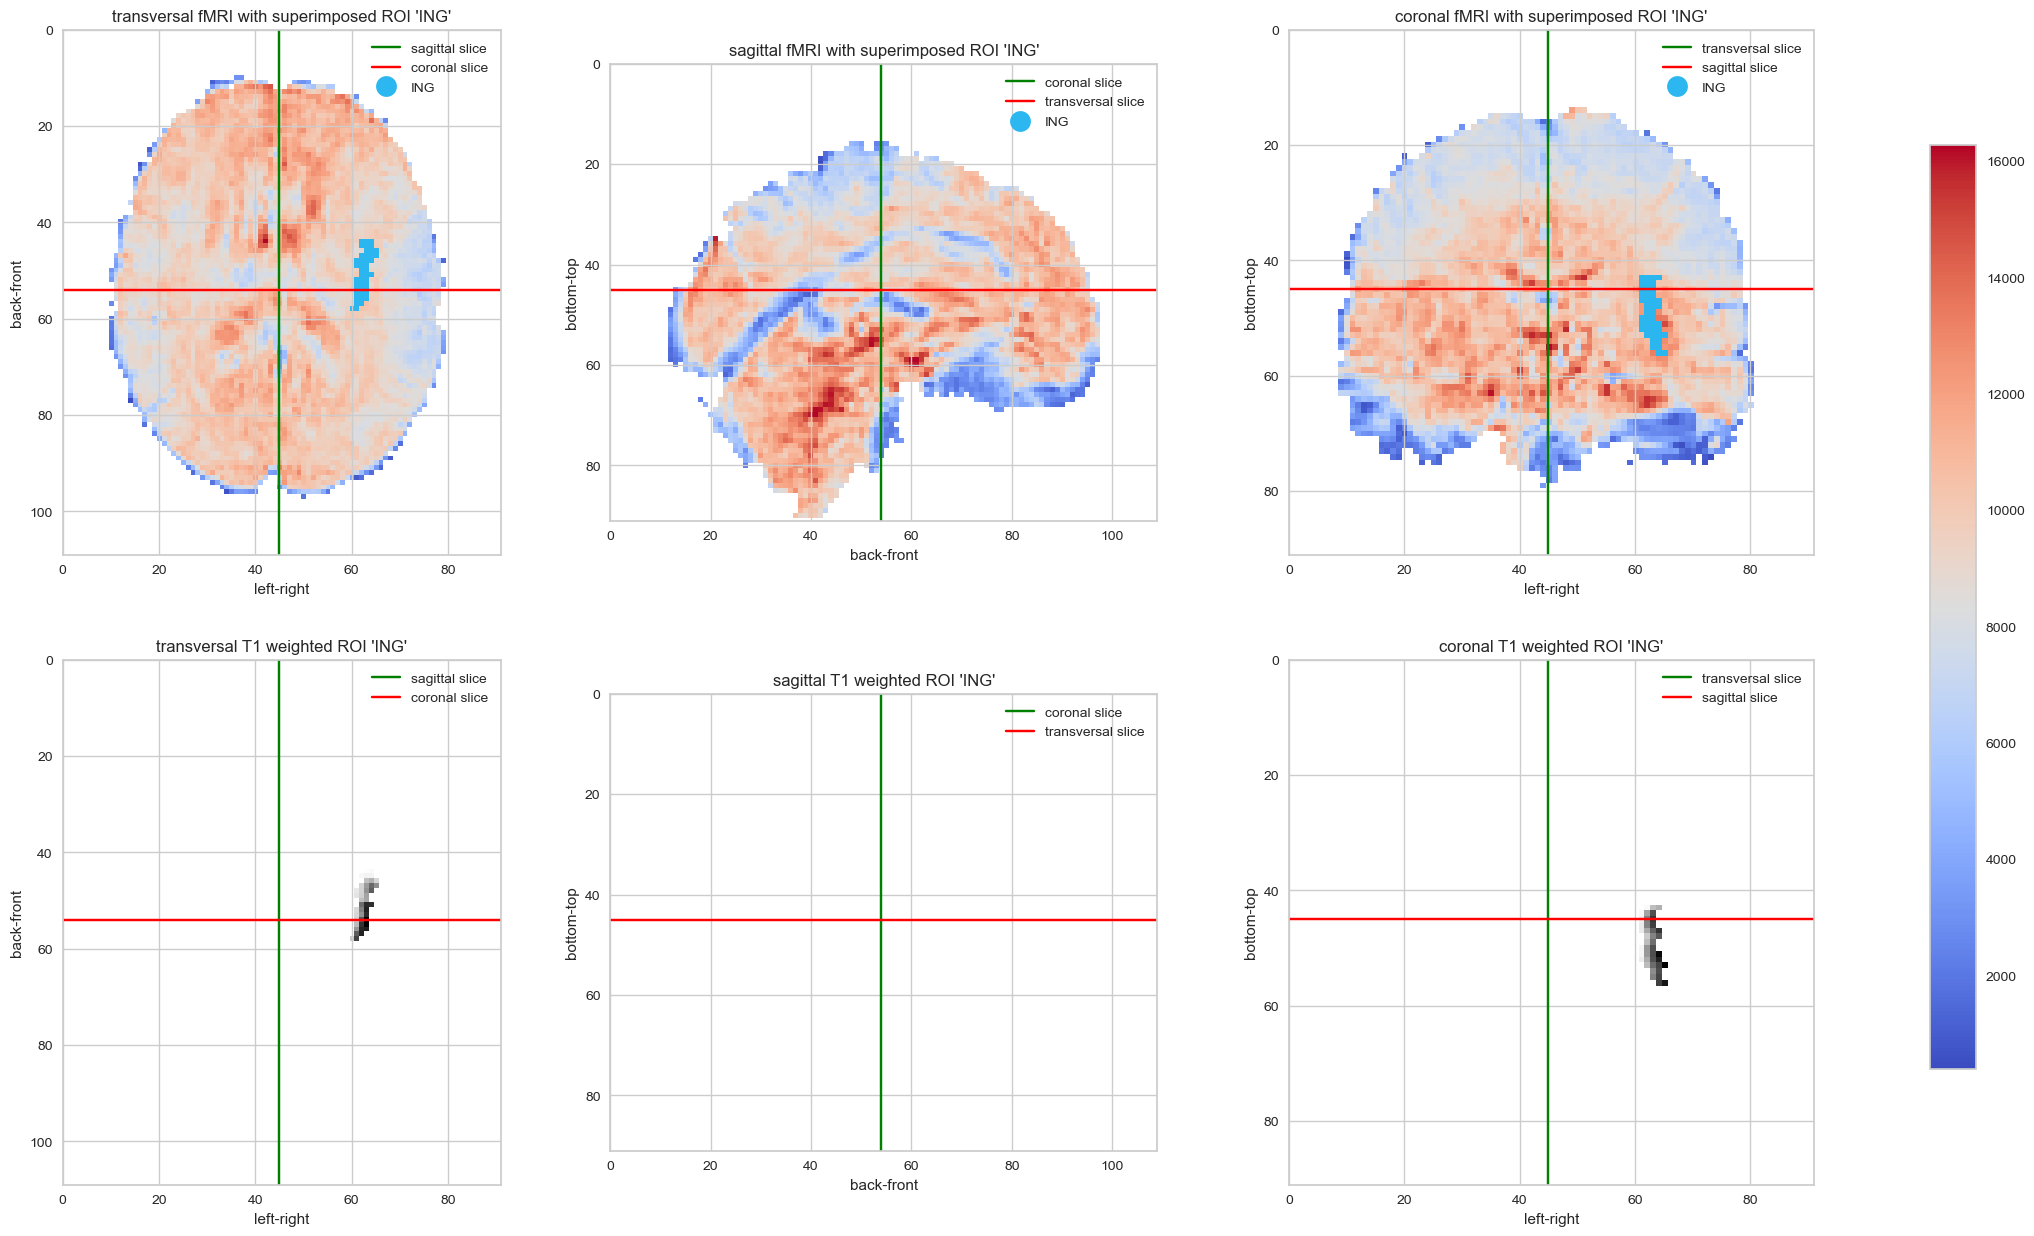

In [16]:
fig, axs = plt.subplots(2,3, figsize=(30,15))
legend_element = [Line2D([0], [0], marker='o', color='w', label=region_to_plot, markerfacecolor=colors[region_index[0], :], markersize=15)] # create legend element for region manually
for plot in np.arange(2):
    for orientation_num, orientation in enumerate(orientations):
        if plot == 0:
            # plot fMRI-image with roi
            image = plot_in_orientation(resampled_img_data_fMRI_masked, orientation, slices[orientation_num], ax=axs[plot, orientation_num], cmap="coolwarm")
            plot_in_orientation(masked_aal_region, orientation, slices[orientation_num], cmap=ListedColormap(colors[region_index, :]), ax=axs[plot, orientation_num], label=region_to_plot)
            axs[plot, orientation_num].set_title(f"{orientation} fMRI with superimposed ROI '{region_to_plot}'")  # set title
        else:
            # plot region
            resampled_img_data_T1w_oneRegionOnly = resampled_img_data_T1w * (region_maps_data == region_id)
            masked_region = np.ma.masked_where(resampled_img_data_T1w_oneRegionOnly == 0, resampled_img_data_T1w_oneRegionOnly)
            plot_in_orientation(masked_region, orientation, slices[orientation_num], ax=axs[plot, orientation_num])
            axs[plot, orientation_num].set_title(f"{orientation} T1 weighted ROI '{region_to_plot}'") # set title

        if orientation_num == 0:
            # transversal ax labels and limits
            axs[plot, 0].set_xlabel("left-right")
            axs[plot, 0].set_ylabel("back-front")
            axs[plot, 0].set_xlim(0, short)
            axs[plot, 0].set_ylim(long, 0)
            # plot slice indicators
            axs[plot, 0].plot([sagittal_slice, sagittal_slice], [0, long], color="green", label="sagittal slice")
            axs[plot, 0].plot([0, short], [coronal_slice, coronal_slice], color="red", label="coronal slice")
            axs[plot, 0].legend()
        elif orientation_num == 1:
            # sagittal ax labels and limits
            axs[plot, 1].set_xlabel("back-front")
            axs[plot, 1].set_ylabel("bottom-top")
            axs[plot, 1].set_xlim(0, long)
            axs[plot, 1].set_ylim(short, 0)
            # plot slice indicators
            axs[plot, 1].plot([coronal_slice, coronal_slice], [0, 91], color="green", label="coronal slice")
            axs[plot, 1].plot([0, 109], [transversal_slice, transversal_slice], color="red", label="transversal slice")
            axs[plot, 1].legend()
        else:
            # coronal ax labels and limits
            axs[plot, 2].set_xlabel("left-right")
            axs[plot, 2].set_ylabel("bottom-top")
            axs[plot, 2].set_xlim(0, short)
            axs[plot, 2].set_ylim(short, 0)
            # plot slice indicators
            axs[plot, 2].plot([transversal_slice, transversal_slice], [0, 91], color="green", label="transversal slice")
            axs[plot, 2].plot([0, 91], [sagittal_slice, sagittal_slice], color="red", label="sagittal slice")
            axs[plot, 2].legend()

        if plot == 0:
            # combine legends from region overlay with slice indicators
            handles, labels = axs[0, orientation_num].get_legend_handles_labels()
            handles += legend_element
            labels += [region_to_plot]
            axs[0, orientation_num].legend(handles, labels)

# add fMRI colorbar (cmap = 'coolwarm')
cbar = fig.colorbar(image, ax=axs.ravel().tolist(), shrink=0.8)

### Visualize Timeseries

The timeseries are calculated by determining the mean value in intensity per region for each point in time. For better visualization mean-centered timeseries was used additionally.

In [10]:
# extract single patients timeseries
timeseries = all_timeseries[subject_num]
timeseries_mean = timeseries - np.mean(timeseries, axis=0)

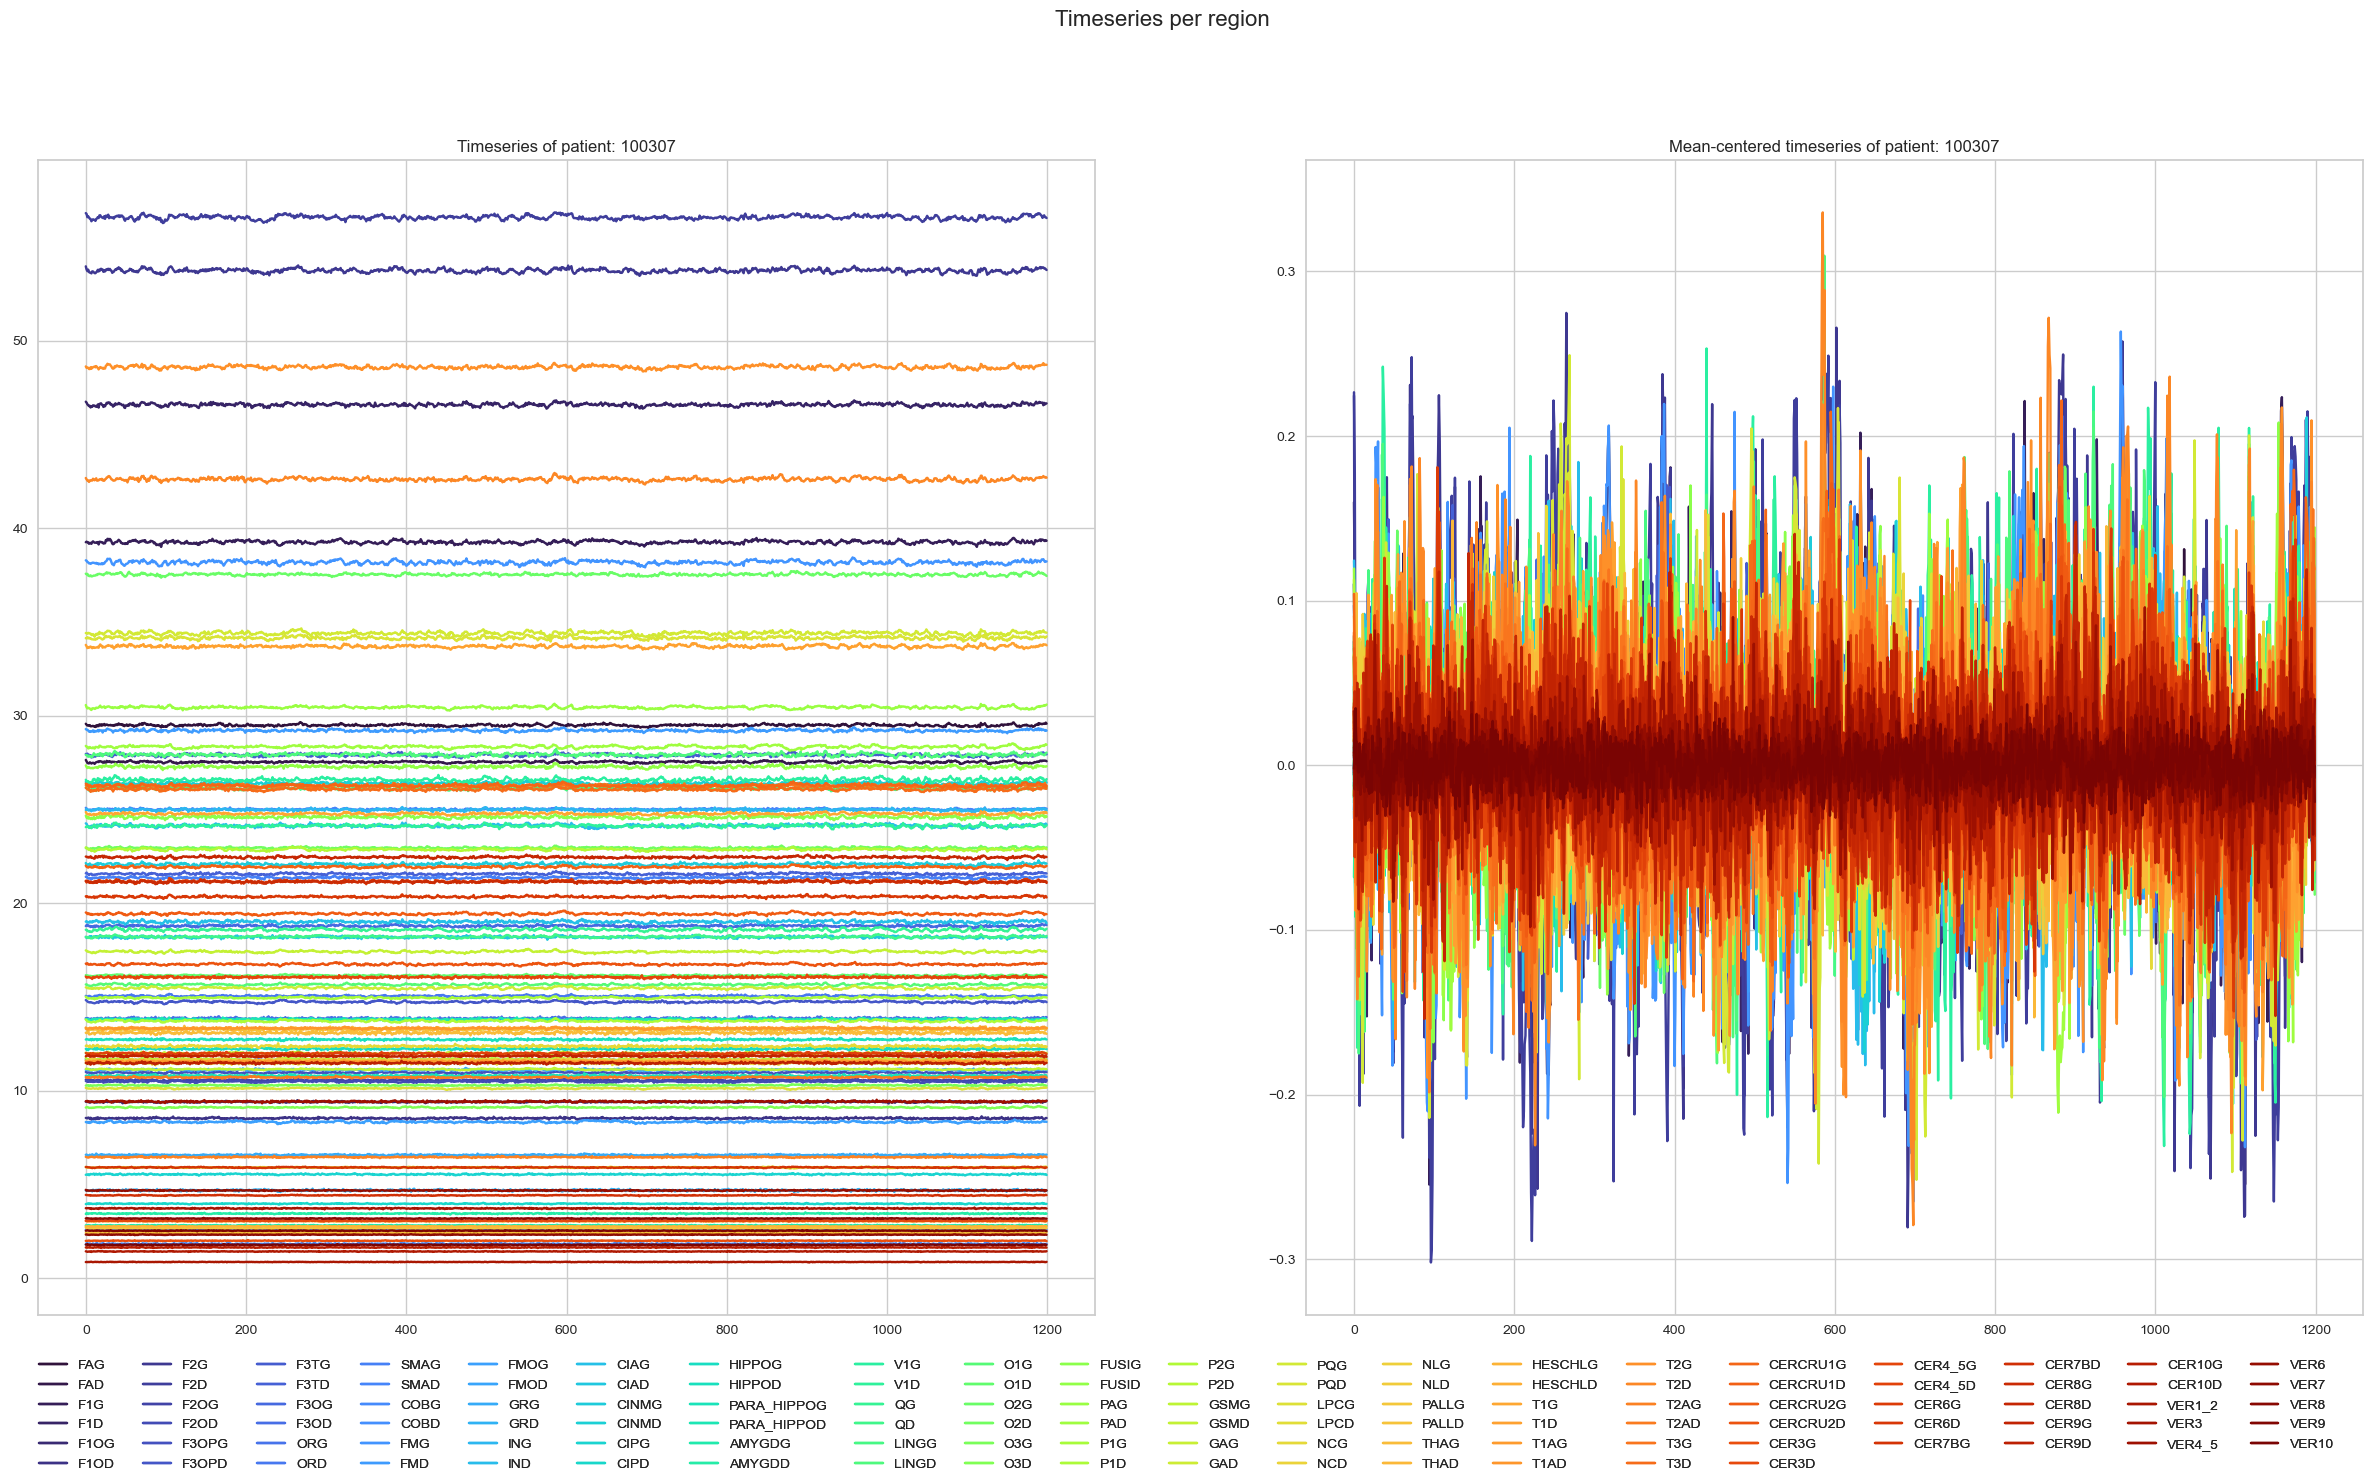

In [11]:
# plot the patients timeseries
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(30, 15))
for region_num in range(regions_n):
    axs[0].plot(timeseries[:, region_num], color=colors[region_num])
    axs[1].plot(timeseries_mean[:, region_num], color=colors[region_num])
fig.suptitle("Timeseries per region", fontsize=16)
axs[0].set_title(f"Timeseries of patient: {subject_id}")
axs[1].set_title(f"Mean-centered timeseries of patient: {subject_id}")
legend = fig.legend(region_labels[:, 0], loc="lower center", ncols=20)
fig.add_artist(legend);

### Compute Pearson's r
For one patient the correlation between all regions has been computed in a sliding window of 5 steps in time width with an overlap of 20%. Pearson's r was used as measure of correlation.
$$ r = {COV(X, Y) \over \sqrt{VAR(X)} \cdot \sqrt{VAR(Y)}} $$

In [12]:
# compute correlation between regions in sliding window
correlation_matrices_per_patient = timeseries_pearson_corr(timeseries, step_width=5, overlap_percentage=0.2)

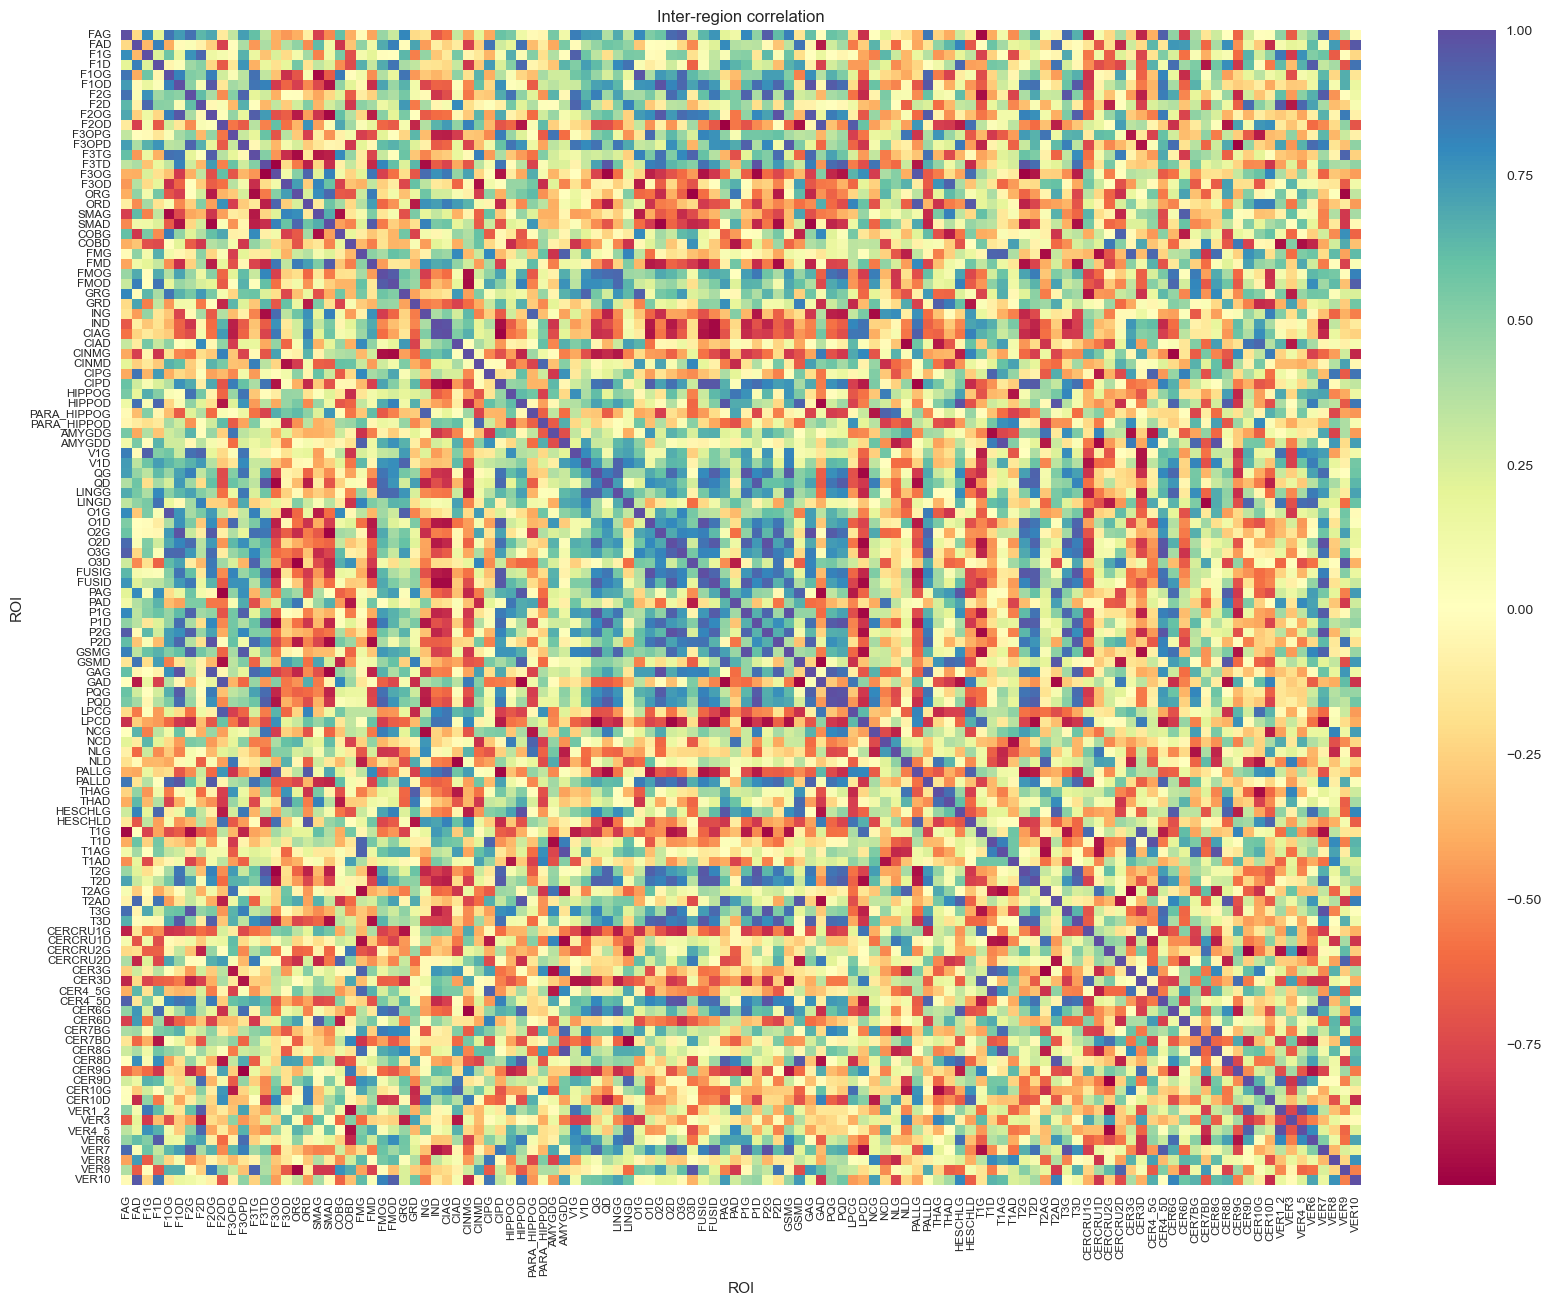

In [18]:
# plot correlation matrix at specific timestamp
axis_labels = region_labels[:, 0]
fig, ax = plt.subplots(figsize=(20,15))
sns.heatmap(correlation_matrices_per_patient[timestamp], ax=ax, cmap='Spectral')
ax.set_title("Inter-region correlation")
ax.set_xlabel("ROI")
ax.set_ylabel("ROI")
ax.set_xticks(np.arange(len(regions))+0.5, axis_labels, fontsize="x-small")
ax.set_yticks(np.arange(len(regions))+0.5, axis_labels, fontsize="x-small");

### Compute and visualize Network Graph and Small World Parameter comparison

A weighted network graph based on one of the formerly computed correlation matrices is generated. The threshold for the visualization was chosen as $t = 0.9$. In addition, the small world parameters average cluster coefficient, average shortest path length and average degree of neighbors have been computed for the generated graph, a regular graph (Watts-Strogatz with $p = 0$) and a random graph (Erdős-Rényi with $p = 0.2$). Also those parameters have been calculated in another project of the same course for different social networks.

|                                  | fMRI  | Facebook | Twitter | arXiv.org citations | Watts-Strogatz <br /> $p = 0$, $n = 116$, $k = 29$ | Erdős-Renyi <br /> $p = 0.2$, $n = 116$ |
|----------------------------------|-------|----------|---------|---------------------|----------------------------------------------------|-----------------------------------------|
| **Threshold**                    | 0.7   | &mdash;  | 0.02    | 0.1                 | &mdash;                                            | &mdash;                                 |
| **Clustering coefficient**       | 0.55  | 0.61     | 0.38    | 0.0                 | 0.72                                               | 0.20                                    |
| **Average shortest path length** | 2.05  | 3.69     | 4.06    | 0.25                | 2.57                                               | 1.81                                    |
| **Average degree of neighbors**  | 24.91 | 43.69    | 35.69   | 1.0                 | 28.0                                               | 23.81                                   |

A video of the three-dimensional network graph over time has also been produced.

In [19]:
# set diagonal to 0 (no correlation of region with itself), compute absolute value to have only positive correlations and set all values <= threshold to 0
for k in np.arange(len(correlation_matrices_per_patient)):
    for l in np.arange(len(regions)):
        correlation_matrices_per_patient[k][l,l] = 0
correlation_matrices_per_patient_abs = np.abs(correlation_matrices_per_patient)
correlation_matrices_per_patient_abs_thresh = correlation_matrices_per_patient_abs * (correlation_matrices_per_patient_abs > correlation_threshold)

correlation_matrices_per_patient_vis = correlation_matrices_per_patient_abs * (correlation_matrices_per_patient_abs > correlation_threshold_for_visualization)    # different threshold for visualization

In [20]:
# compute network graph
graph = nx.from_numpy_array(correlation_matrices_per_patient_abs_thresh[timestamp])

In [21]:
# compute network graph for visualization
graph_vis = nx.from_numpy_array(correlation_matrices_per_patient_vis[timestamp])

In [84]:
# regular graph for comparison
graph_regular = nx.watts_strogatz_graph(n=116, k=int(116/4), p=0)
average_clustering_coefficient = nx.average_clustering(graph_regular)
average_shortest_path_length = nx.average_shortest_path_length(graph_regular)
average_neighbor_degree = np.mean(list(nx.average_neighbor_degree(graph_regular).values()))
average_clustering_coefficient, average_shortest_path_length, average_neighbor_degree

(0.7222222222222233, 2.5652173913043477, 28.0)

In [74]:
# random graph for comparison
graph_random = nx.erdos_renyi_graph(n=116, p=0.2)
average_clustering_coefficient = nx.average_clustering(graph_random)
average_shortest_path_length = nx.average_shortest_path_length(graph_random)
average_neighbor_degree = np.mean(list(nx.average_neighbor_degree(graph_random).values()))
average_clustering_coefficient, average_shortest_path_length, average_neighbor_degree

(0.1996663384559156, 1.8073463268365817, 23.812008452890055)

In [42]:
# compute small world parameters
average_clustering_coefficient = nx.average_clustering(graph)
average_shortest_path_length = nx.average_shortest_path_length(graph)
average_neighbor_degree = np.mean(list(nx.average_neighbor_degree(graph).values()))

In [45]:
# print small world parameters
average_clustering_coefficient, average_shortest_path_length, average_neighbor_degree

(0.5463646619119619, 2.0464767616191906, 24.907882718861114)

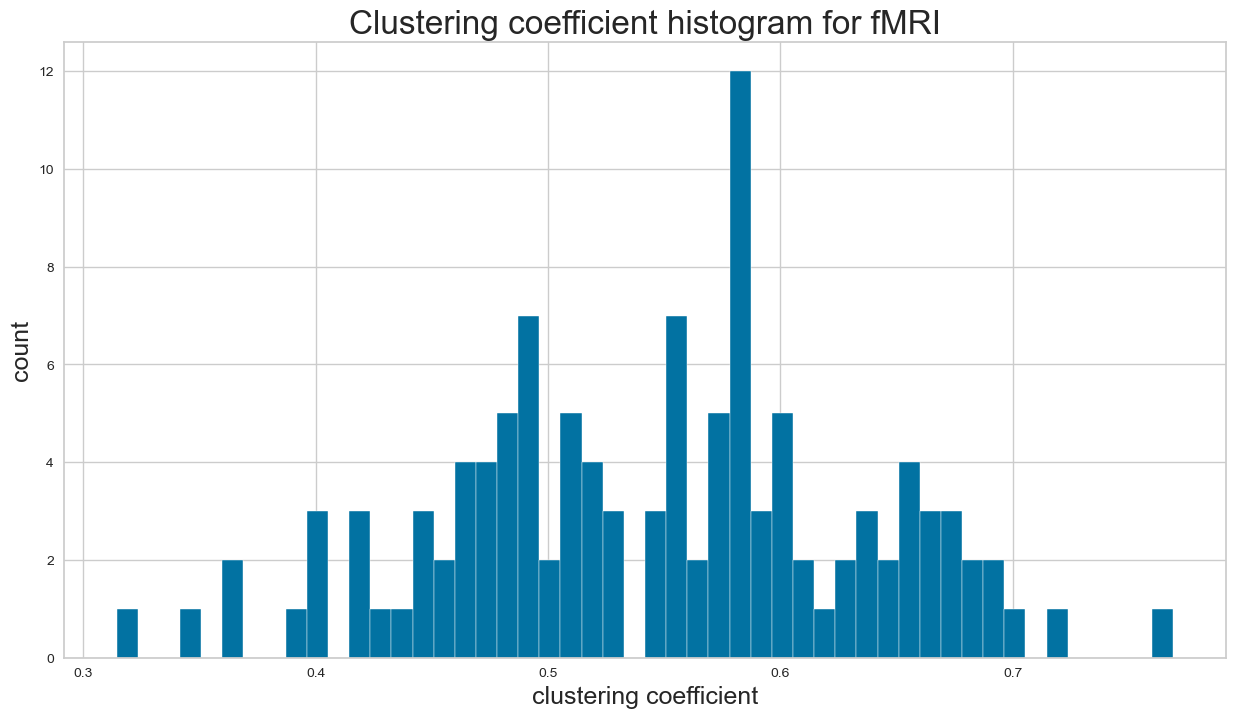

In [23]:
# compute clustering coefficient histogram
plt.figure(figsize=(15, 8))
plt.hist(nx.clustering(graph).values(), bins=50)
plt.title("Clustering coefficient histogram for fMRI", fontdict={"size": 24}, loc="center")
plt.xlabel("clustering coefficient", fontdict={"size": 18})
plt.ylabel("count", fontdict={"size": 18});

In [24]:
# compute weights of connections based on correlation
all_weights = []
for (node1, node2, data) in graph_vis.edges(data=True):
    all_weights.append(correlation_matrices_per_patient_vis[timestamp][node1, node2])

In [25]:
# change centroid positions
files = glob("./Data/centroids/*")
all_centroids = np.concatenate([np.load(file) for file in files], axis=0)
all_centroids_new = all_centroids.copy()
center_x, center_y, center_z = np.array(masked_aal.shape) / 2
for centroid in np.arange(all_centroids.shape[0]):
    # mirror node positions on center of x-Axis
    if all_centroids[centroid, 0] < center_x:
        all_centroids_new[centroid, 0] = center_x + (center_x - (all_centroids[centroid, 0]))
    elif all_centroids[centroid, 0] > center_x:
        all_centroids_new[centroid, 0] = center_x - ((all_centroids[centroid, 0]) - center_x)
    # mirror node positions on center of y-Axis (not necessary)
    # if all_centroids[centroid, 1] < center_y:
    #     all_centroids_new[centroid, 1] = center_y + (center_y - (all_centroids[centroid, 1]))
    # elif all_centroids[centroid, 1] > center_y:
    #     all_centroids_new[centroid, 1] = center_y - ((all_centroids[centroid, 1]) - center_y)
    # mirror node positions on center of z-Axis
    if all_centroids[centroid, 2] < center_z:
        all_centroids_new[centroid, 2] = center_z + (center_z - (all_centroids[centroid, 2]))
    elif all_centroids[centroid, 2] > center_z:
        all_centroids_new[centroid, 2] = center_z - ((all_centroids[centroid, 2]) - center_z)

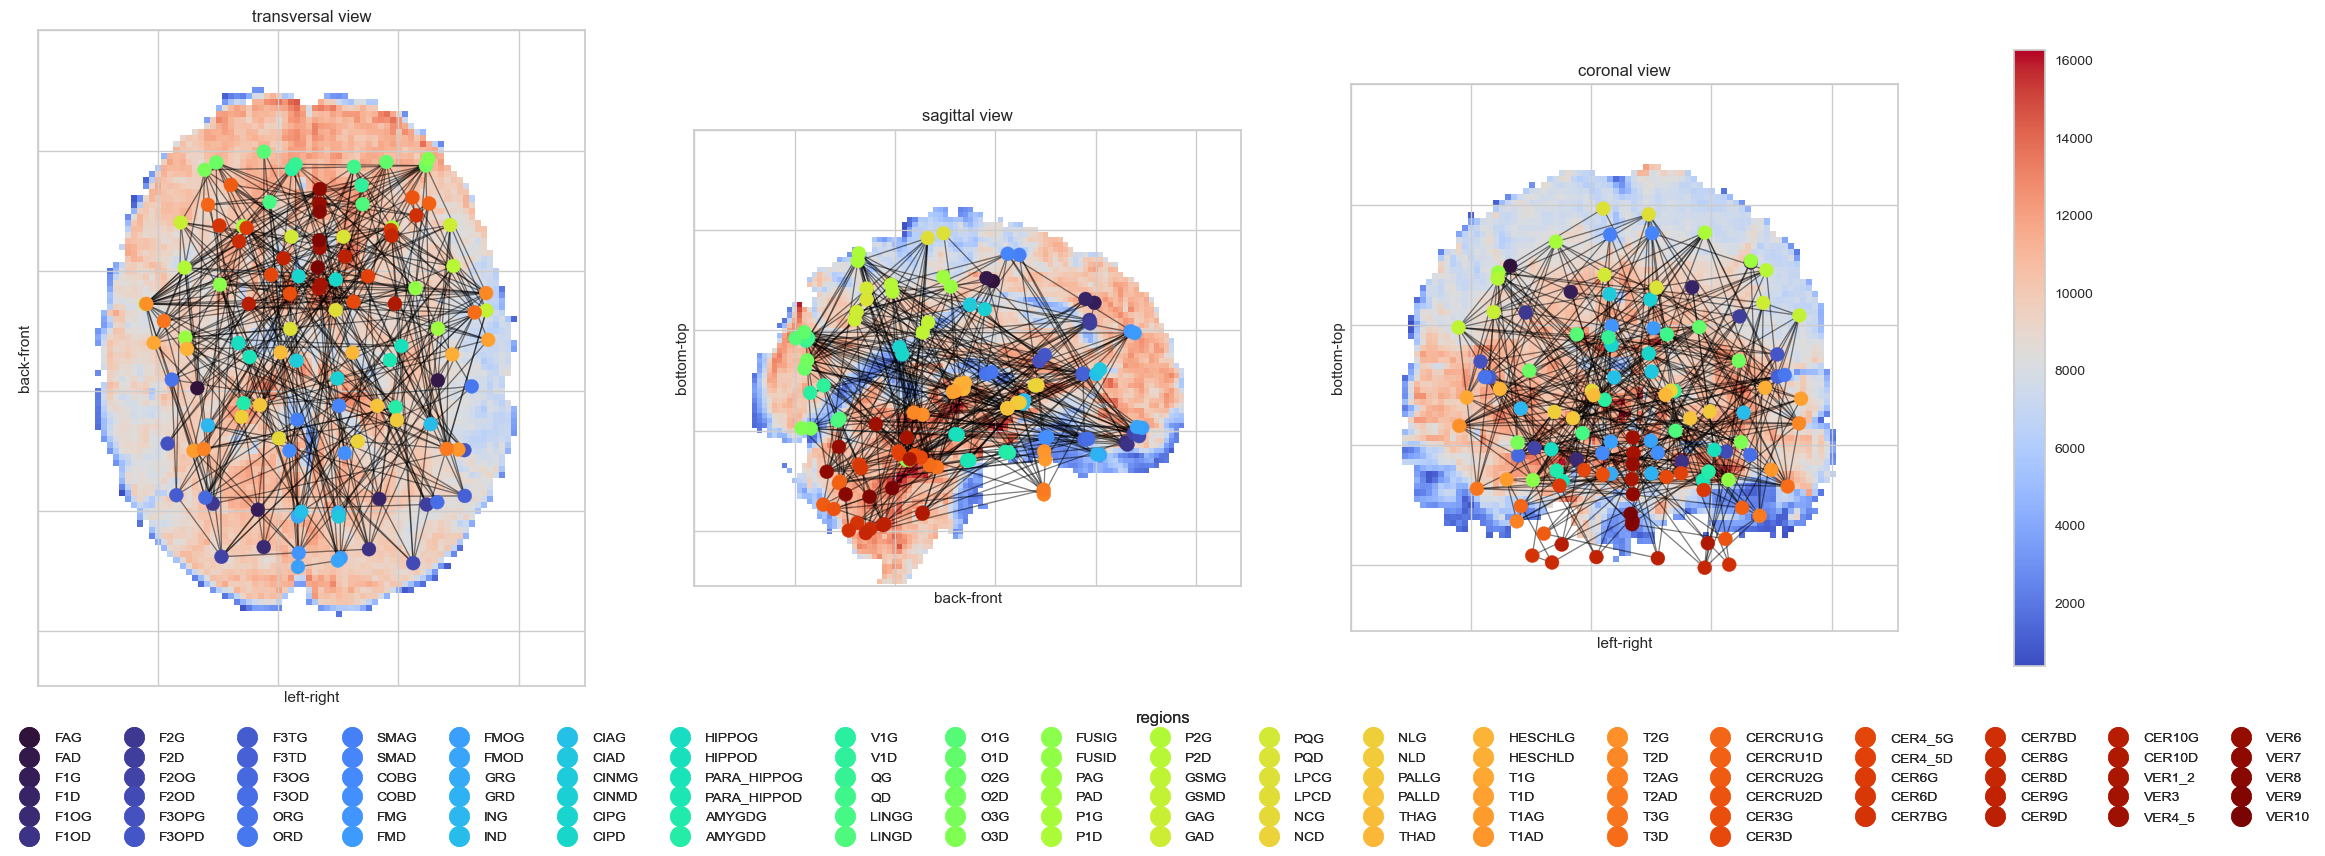

In [26]:
# plot 2D network graph with custom node positions
fig, axs = plt.subplots(1, 3, figsize=(30, 10))
views = [all_centroids_new[:, 0:2], all_centroids_new[:, 1:3], all_centroids_new[:, 0:3:2]]
titles = ["transversal view", "sagittal view", "coronal view"]
pos = []
for ax_num, ax in enumerate(axs):
    image = plot_in_orientation(resampled_img_data_fMRI_masked, orientations[ax_num], slices[ax_num], ax=axs[ax_num], cmap="coolwarm")
    pos.append(views[ax_num])   # could be also done by using views[ax_num] instead of pos[x_num] in next two lines
    nx.draw_networkx_nodes(graph_vis, pos=pos[ax_num], alpha=1, node_size=100, node_color=range(len(regions)), ax=ax, cmap="turbo", )
    nx.draw_networkx_edges(graph_vis, pos=pos[ax_num], alpha=0.5, node_size=100, edge_color="black", width=all_weights, ax=ax)
    ax.set_title(titles[ax_num])
# set Axis labels and limits
axs[0].set_xlabel("left-right")
axs[0].set_ylabel("back-front")
axs[1].set_ylabel("bottom-top")
axs[1].set_xlabel("back-front")
axs[2].set_xlabel("left-right")
axs[2].set_ylabel("bottom-top")
axs[0].set_xlim(0, short)
axs[0].set_ylim(long, 0)
axs[1].set_xlim(0, long)
axs[1].set_ylim(short, 0)
axs[2].set_xlim(0, short)
axs[2].set_ylim(short, 0)
# generate legend
legend_elements = [Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=colors[label_num], markersize=15) for label_num, label in enumerate(list(region_labels[:, 0]))]
legend = fig.legend(handles = legend_elements, labels=list(region_labels[:, 0]), loc="lower center", title="regions", ncols=20)
fig.add_artist(legend)
# generate colorbar
cbar = fig.colorbar(image, ax=axs.ravel().tolist(), shrink=0.8)

In [38]:
# image transposing for different views (same as in plot_in_orientation)
coronal = np.transpose(resampled_img_data_T1w, [0, 2, 1])
coronal = np.rot90(coronal, 3)
coronal_image = coronal[:, :, coronal_slice]
sagittal = np.transpose(resampled_img_data_T1w, [1, 2, 0])
sagittal = np.rot90(sagittal, 0)
sagittal_image = sagittal[:, :, sagittal_slice]
transversal = np.transpose(resampled_img_data_T1w, [0, 1, 2])
transversal = np.rot90(transversal, 3)
transversal_image = transversal[:, :, transversal_slice]

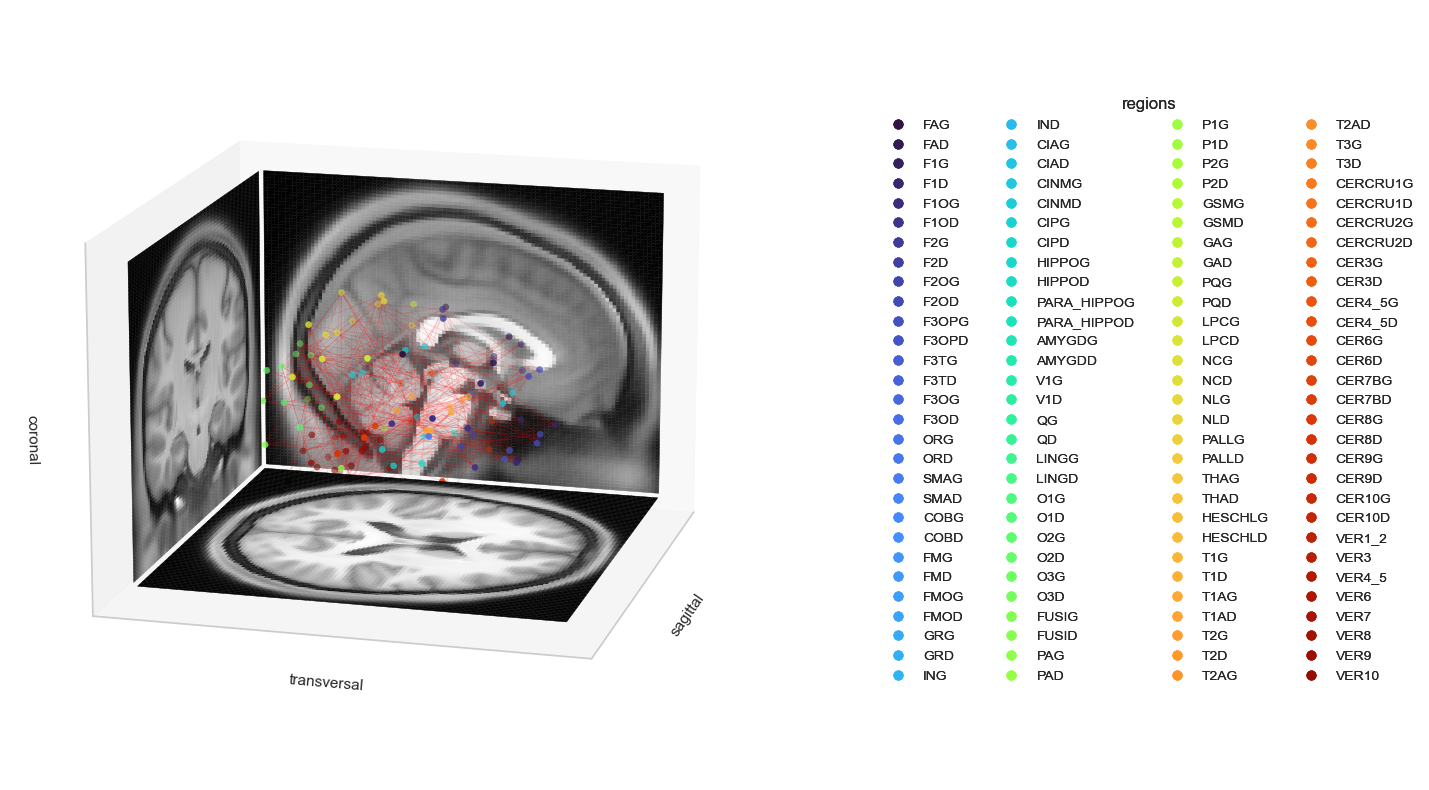

In [39]:
# get positions
pos = all_centroids
node_pos = pos
edge_pos = np.array([(pos[u], pos[v]) for u, v in graph_vis.edges]) # u = Node1, v = Node2
# set plot
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(projection='3d')
# plot background images (x, y, z are the coordinate for the image plane)
x1, y1 = np.meshgrid(np.linspace(0, transversal.shape[1], transversal.shape[1]), np.linspace(0, transversal.shape[0], transversal.shape[0]))
z1 = np.ones(x1.shape) * -1 # offset by -1
ax.plot_surface(x1, y1, z1, rstride=1, cstride=1, facecolors=plt.cm.gray(transversal_image / transversal_image.max()), shade=False)
x2, z2 = np.meshgrid(np.linspace(0, coronal.shape[0], coronal.shape[0]), np.linspace(0, coronal.shape[1], coronal.shape[1]))
y2 = np.ones(x2.shape) * -1 # offset by -1
ax.plot_surface(x2, y2, z2, rstride=1, cstride=1, facecolors=plt.cm.gray(coronal_image / coronal_image.max()), shade=False)
z3, y3 = np.meshgrid(np.linspace(0, sagittal.shape[1], sagittal.shape[1]), np.linspace(0, sagittal.shape[0], sagittal.shape[0]))
x3 = np.ones(z3.shape) * -1 # offset by -1
ax.plot_surface(x3, y3, z3, rstride=1, cstride=1, facecolors=plt.cm.gray(sagittal_image / sagittal_image.max()), shade=False)
# plot nodes
scatter = ax.scatter3D(*node_pos.T, c=regions, s=20, cmap="turbo")
# plot edges
for edge_num in np.arange(edge_pos.shape[0]):
    ax.plot3D(xs=(edge_pos[edge_num, 0, 0], edge_pos[edge_num, 1, 0]), ys=(edge_pos[edge_num, 0, 1], edge_pos[edge_num, 1, 1]), zs=(edge_pos[edge_num, 0, 2], edge_pos[edge_num, 1, 2]), color="red", linewidth=all_weights[edge_num] * 0.5, alpha=0.2)
# set viewing angle
ax.view_init(15, 15)
# generate legend
legend = fig.legend(handles = scatter.legend_elements(num=len(regions))[0], labels=list(region_labels[:, 0]), bbox_to_anchor=(1.2, 0.5), loc="right", title="regions", ncols=4)
fig.add_artist(legend)
# set Axis labels and remove ticks
ax.set_xlabel("sagittal")
ax.set_ylabel("transversal")
ax.set_zlabel("coronal")
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([]);

In [19]:
# generate single frames for video animation
create_network_graph_frames(resampled_img_data_T1w, (coronal_slice, sagittal_slice, transversal_slice), correlation_matrices_per_patient_vis, all_centroids, regions, region_labels)

All figures saved.


In [20]:
# generate video
# code adapted based on code by BoboDarph under https://stackoverflow.com/questions/44947505/how-to-make-a-movie-out-of-images-in-python and code under https://note.nkmk.me/en/python-sort-num-str/

image_folder = './Data/video'
video_name = './Data/video.mp4' # choose export folder, filename and video container

images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
images = sorted(images, key=lambda s: int(re.search(r'\d+', s).group()))    # sorting by number (1, ..., 10 instead of 1, 10, ...)
frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape

fourcc = cv2.VideoWriter_fourcc(*'h264')    # choose fourcc for videocodec

video = cv2.VideoWriter(video_name, fourcc, 12, (width,height))

for image in images:
    video.write(cv2.imread(os.path.join(image_folder, image)))

cv2.destroyAllWindows()
video.release()

### Supervised Learning

In [48]:
# get upper triangular areas of correlation matrices for all patients
X = np.zeros((100, len(correlation_matrices_per_patient) * int(0.5 * len(regions) * (len(regions) - 1))))
index = 0
for subject_id in subjects:
    subject_num = subjects.index(subject_id)
    # extract single patients timeseries
    timeseries = all_timeseries[subject_num]
    # compute correlation between regions in sliding window
    correlation_matrices_per_patient = timeseries_pearson_corr(timeseries, step_width=5, overlap_percentage=0.2)
    upper_triangular_matrices = []
    for matrix in correlation_matrices_per_patient:
        upper_triangular_indices = np.triu_indices_from(matrix, k=1)
        upper_triangular_matrices.append(matrix[upper_triangular_indices])
    X[index, :] = np.array(upper_triangular_matrices).reshape(1, -1)
    index += 1

In [9]:
# use gender as labels
y = gender

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [63]:
RF = RandomForestClassifier()
RF.fit(X_train, y_train)

RandomForestClassifier()

In [64]:
RF.score(X_test, y_test)

0.32